# Exponential generated dwarf experiments

Start with an exponential profile due to its analytic relative simplicity. Later can try sersic.

In [1]:
import numpy as np

from regions import CirclePixelRegion, PixCoord, RectanglePixelRegion

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sympy

In [4]:
oo = sympy.oo
Re, α, b = sympy.symbols('R_e,α,b', real=True, positive=True)
R, A, θ, x = sympy.symbols('R,A,θ,x', real=True)

In [5]:
I = A * sympy.exp(-R/α)
I

A*exp(-R/α)

In [6]:
sympy.integrate(I*R, (R, 0, oo))

A*α**2

In [7]:
norm = sympy.Integral(sympy.Integral(I*R, (R, 0, oo)), (θ, 0, 2*sympy.pi))
norm

Integral(A*R*exp(-R/α), (R, 0, oo), (θ, 0, 2*pi))

In [8]:
norm.doit()

2*pi*A*α**2

In [9]:
Asoln = sympy.solve(sympy.Eq(norm.doit(), 1), A)[0]
sympy.Eq(A, Asoln)

Eq(A, 1/(2*pi*α**2))

In [10]:
hlint = sympy.Integral(sympy.Integral(I*R, (R, 0, Re)), (θ, 0, 2*sympy.pi))
hlint

Integral(A*R*exp(-R/α), (R, 0, R_e), (θ, 0, 2*pi))

In [11]:
hlints = hlint.subs(A, Asoln)
hlints

Integral(R*exp(-R/α)/(2*pi*α**2), (R, 0, R_e), (θ, 0, 2*pi))

In [12]:
sympy.simplify(hlints.doit())

(-R_e + α*exp(R_e/α) - α)*exp(-R_e/α)/α

In [13]:
sympy.solve(Re, sympy.Eq(hlints.doit(), sympy.Rational(1,2)))

[]

b = Re/α

In [14]:
sympy.simplify(hlints.doit().subs(α, Re/b))

(-b + exp(b) - 1)*exp(-b)

In [15]:
bval = float(sympy.nsolve(sympy.simplify(hlints.doit().subs(α, Re/b))-sympy.Rational(1,2), b, 1))
bval

1.6783469900166605

In [16]:
Inorm = I.subs(A, Asoln).subs(α, Re/b)
Inorm

b**2*exp(-R*b/R_e)/(2*pi*R_e**2)

In [17]:
CDF = sympy.integrate(Inorm*R*2*sympy.pi, (R, 0, x))
CDF


1 + (-R_e - b*x)*exp(-b*x/R_e)/R_e

In [18]:
F = sympy.symbols('F', positive=True, real=True)
isoln = sympy.solve(sympy.Eq(CDF, F), x)[0]
isoln

R_e*(-LambertW((F - 1)*exp(-1)) - 1)/b

In [19]:
CDF.subs({b:bval, Re:1, x:1000}).evalf()

1.00000000000000

In [20]:
np.isscalar([1])

False

In [21]:
from scipy.special import lambertw

def expinteg(F, Re, b=bval):
    sc = np.isscalar(F)
    res = np.atleast_1d(-Re*(lambertw((F-1)/np.exp(1), -1).real + 1)/b)
    res.ravel()[np.isnan(res.ravel())] = 0
    return res[0] if sc else res
expinteg(0.5, 1)

np.float64(1.0)

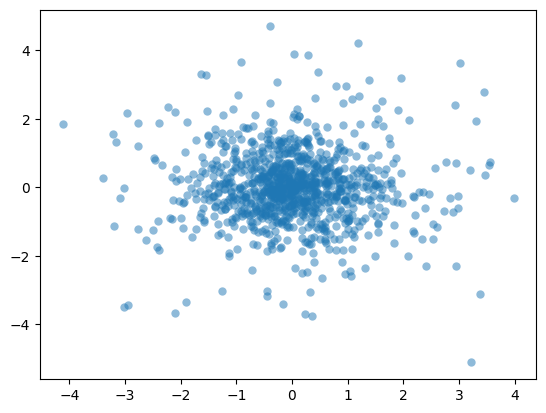

In [22]:
def generate_dglx(n, Re, region=None, rstate=np.random.RandomState()):
    U = rstate.uniform(0, 1, n)
    r = expinteg(U, Re)
    phi = rstate.uniform(0, 2*np.pi, n)

    x = np.cos(phi)*r
    y = np.sin(phi)*r

    if region is not None:
        msk = region.contains(PixCoord(x, y))
        x = x[msk]
        y = y[msk]

    return x, y

plt.scatter(*generate_dglx(1000, 1), alpha=.5, lw=0)

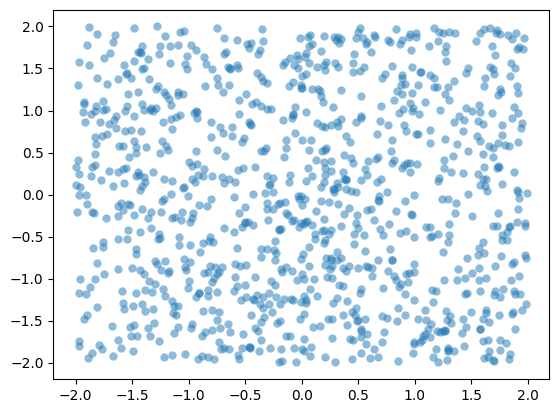

In [23]:
def generate_unif_box(n=None, halfsize=1, density=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        A = (halfsize*2)**2
        n = density * A
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    x = rstate.uniform(-halfsize, halfsize, n)
    y = rstate.uniform(-halfsize, halfsize, n)

    return x, y
plt.scatter(*generate_unif_box(1000, 2), alpha=.5, lw=0)

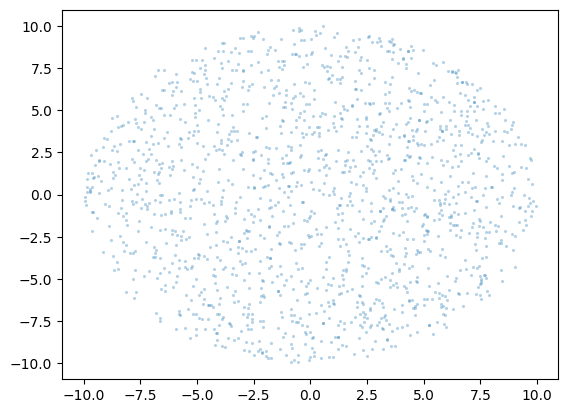

In [24]:
def uniform_in_region(density, region):
    maxpx = np.max(region.bounding_box.extent)
    xs, ys = generate_unif_box(halfsize=maxpx, density=density)
    msk = region.contains(PixCoord(xs, ys))

    return xs[msk], ys[msk]
plt.scatter(*uniform_in_region(5, CirclePixelRegion(PixCoord(0, 0), 10)), alpha=.33, lw=0, s=5)

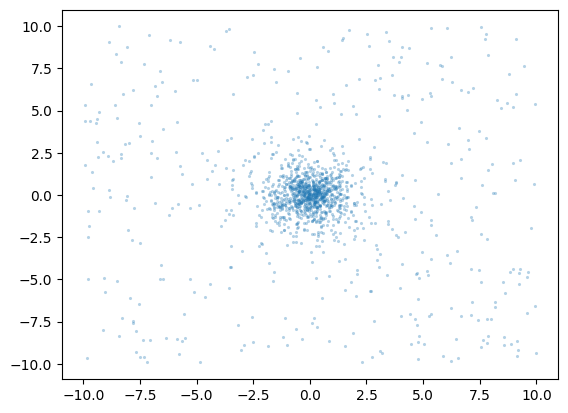

In [25]:
plt.scatter(*np.concatenate([generate_unif_box(400, 10), generate_dglx(1000, 1)], axis=1), alpha=.33, lw=0, s=5)

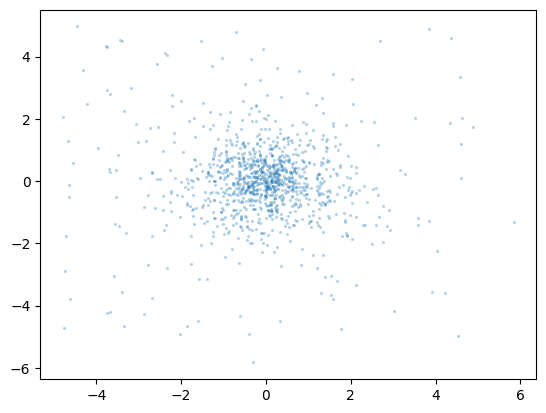

In [26]:
plt.scatter(*np.concatenate([generate_unif_box(halfsize=5, density=1), generate_dglx(1000, 1)], axis=1), alpha=.33, lw=0, s=5)

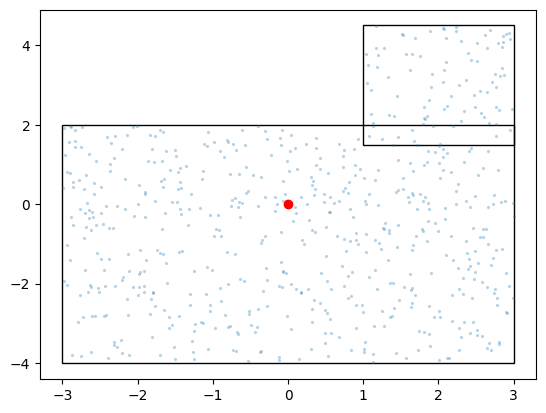

In [27]:
offset_region1 = RectanglePixelRegion(PixCoord(2, 3), 2, 3)
offset_region2 = RectanglePixelRegion(PixCoord(0, -1), 6, 6)

offset_regions = offset_region1 | offset_region2

offset_region1.plot()
offset_region2.plot()

plt.scatter(*uniform_in_region(15, offset_regions), alpha=.33, lw=0, s=5)
plt.scatter([0], [0], c='r')

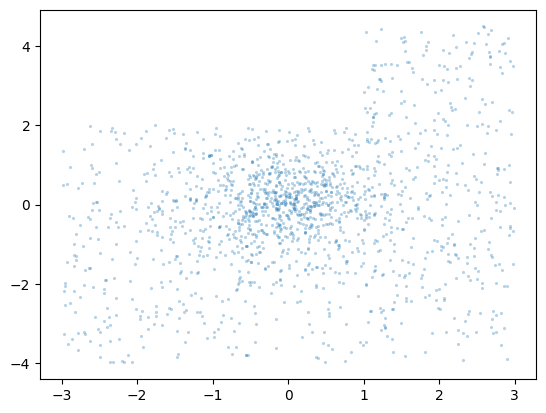

In [28]:
dglx = generate_dglx(1000, 1, offset_regions)
bkg = uniform_in_region(15, offset_regions)

plt.scatter(*np.concatenate((bkg, dglx), axis=1), alpha=.33, lw=0, s=5)